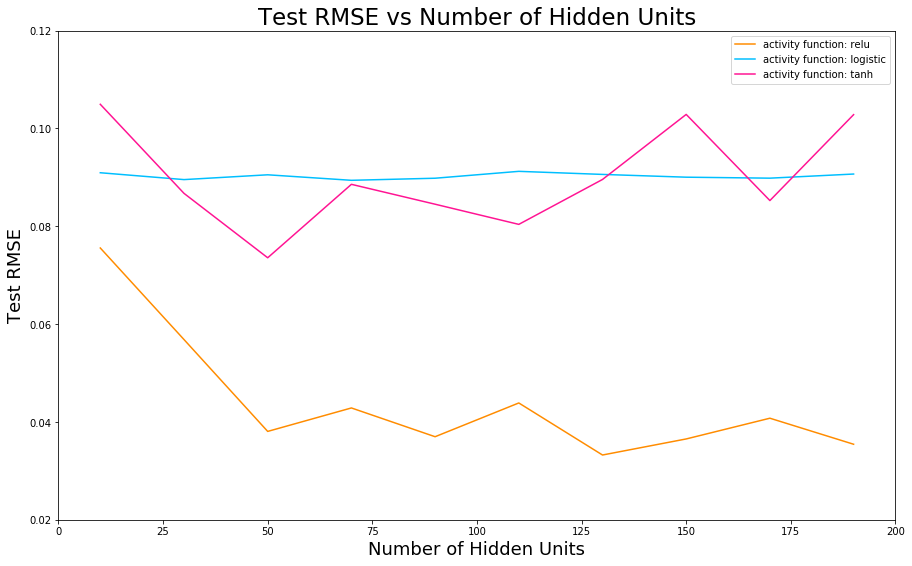

The best combination is:
('relu', 130)


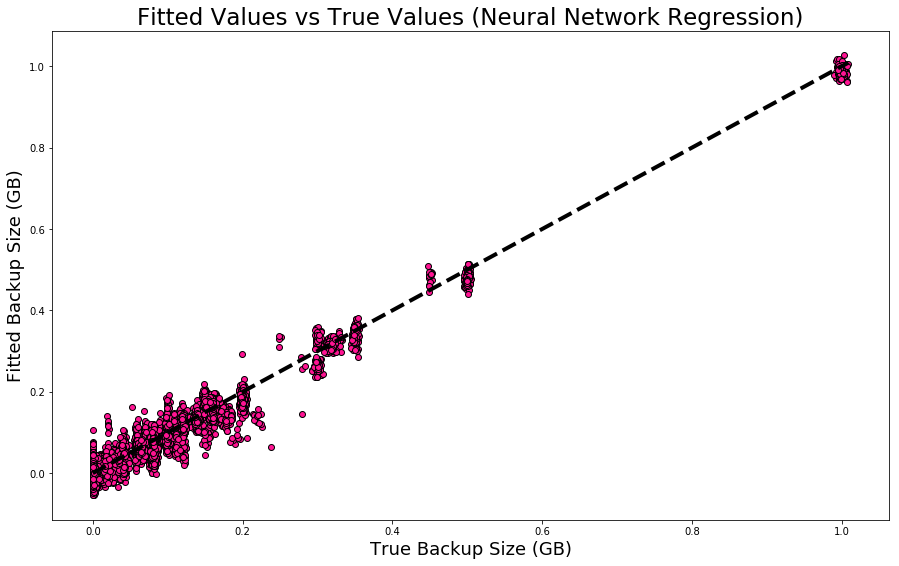

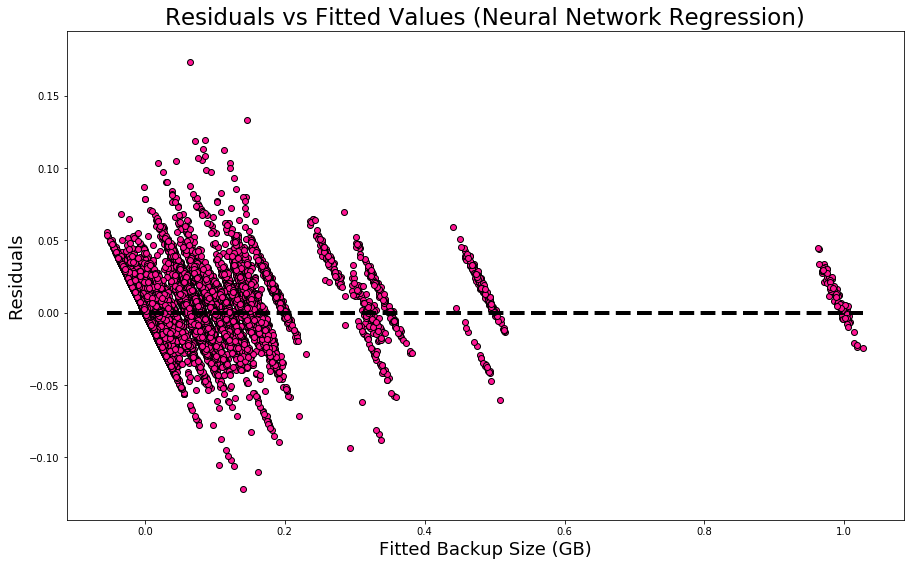

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor


# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))
    
    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace = True)       

# 1 encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2 encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3 encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# extract input and output
input_arr = []
for row in range(len(data)):
    input_arr.append(data.loc[row, 'week':'file_name'].values)

output_arr = data.loc[:, 'size'].values

def one_hot_encoding(input_arr, one_hot_pos):
    enc = OneHotEncoder(n_values='auto', categorical_features=one_hot_pos, 
                        sparse=False, handle_unknown='error')
    return enc.fit_transform(input_arr)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def get_x_y(activation):
    x_y = {}
    for hidden_units in range(10, 200, 20):
        reg = MLPRegressor(hidden_layer_sizes=(hidden_units, ), activation=activation)
        kf = KFold(n_splits=10, shuffle=False)
        
        test_rmses = []
        for train_index, test_index in kf.split(tranformed_input):
            train_in = [tranformed_input[i] for i in train_index]
            train_out = [output_arr[i] for i in train_index]
            test_in = [tranformed_input[i] for i in test_index]
            test_out = [output_arr[i] for i in test_index]
            reg.fit(train_in, train_out)
            test_pre = reg.predict(test_in)
            test_rmses.append(rmse(test_pre, test_out))
        
        x_y[hidden_units] = np.mean(test_rmses)
    return x_y

combine = 31
one_hot_pos = []
for pos in range(5):
    if ((combine >> pos) & 1) == 1:
        one_hot_pos.append(pos)
tranformed_input = one_hot_encoding(input_arr, one_hot_pos)

activation_x_y = {}
for activation in ['relu','logistic', 'tanh']:
    activation_x_y[activation] = get_x_y(activation)

# plot test RMSE vs number of hidden units
plt.figure(figsize=(15,9))
plt.plot(range(10, 200, 20), list(activation_x_y['relu'].values()), 'darkorange', label='activity function: relu')
plt.plot(range(10, 200, 20), list(activation_x_y['logistic'].values()), 'deepskyblue', label='activity function: logistic')
plt.plot(range(10, 200, 20), list(activation_x_y['tanh'].values()), 'deeppink', label='activity function: tanh')
plt.xlabel('Number of Hidden Units', fontsize=18)
plt.ylabel('Test RMSE', fontsize=18)
plt.title('Test RMSE vs Number of Hidden Units', fontsize=23)
plt.axis([0, 200, 0.02, 0.12])
plt.legend(loc='upper right')
plt.show()

# find optimal combination
min_y = float("inf")
optimal_com = None
for key in activation_x_y:
    x_y = activation_x_y[key]
    for x in x_y:
        if x_y[x] < min_y:
            min_y = x_y[x]
            optimal_com = (key, x)
print ('The best combination is:')
print (optimal_com)

reg = MLPRegressor(hidden_layer_sizes=(130, ), activation='relu')
reg.fit(tranformed_input, output_arr)
all_pre = reg.predict(tranformed_input)
residuals = np.subtract(output_arr, all_pre)
final_rmse = rmse(all_pre, output_arr)

# plot fitted values vs true values
plt.figure(figsize=(15,9))
plt.scatter(output_arr, all_pre, color='deeppink', edgecolors='k')
plt.plot([output_arr.min(), output_arr.max()], [output_arr.min(), output_arr.max()], 'k--', lw=4)
plt.ylabel('Fitted Backup Size (GB)', fontsize = 18)
plt.xlabel('True Backup Size (GB)', fontsize = 18)
plt.title('Fitted Values vs True Values (Neural Network Regression)', fontsize = 23)
plt.show()

# plot residuals vs fitted values
plt.figure(figsize=(15,9))
plt.scatter(all_pre, residuals, color='deeppink', edgecolors='k')
plt.plot([all_pre.min(), all_pre.max()], [0, 0], 'k--', lw=4)
plt.ylabel('Residuals', fontsize = 18)
plt.xlabel('Fitted Backup Size (GB)', fontsize = 18)
plt.title('Residuals vs Fitted Values (Neural Network Regression)', fontsize = 23)
plt.show()
